In [1]:
from equadratures import polytree
    
import sys
import random
import numpy as np
import scipy.stats as st
import time
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.lines as mlines
%matplotlib inline
from copy import deepcopy

In [2]:
def f_1(x, noise):
    
    if noise:
        noise = 0.1 * st.norm.rvs(0, 1)
    else:
        noise = 0
    if x < 0.5:
        return 25*(x-0.25)**2 - 1.0625 + noise
    elif x > 0.5:
        return 25*(x-0.75)**2 - 1.0625 + noise
    
def sample_1():
    X, y = [], []
    for i in range(100):
        x = random.random()    
        X.append(np.array([x]))
        y.append(np.array([f_1(x, True)]))
    return np.array(X), np.array(y)

X, y = sample_1()
y = np.reshape(y, (y.shape[0], 1))

start = time.time()
tree = polytree.PolyTree(min_samples_leaf=20, logging=True)
tree.fit(X, y)
duration = time.time() - start

In [3]:
tree.get_graphviz(['x'], 'graph')

GraphViz source file written to graph.txt and can be viewed using an online renderer. Alternatively you can install graphviz on your system to render locally


Traceback (most recent call last):
  File "/home/barney/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/home/barney/.local/lib/python3.8/site-packages/matplotlib/animation.py", line 951, in _start
    self._init_draw()
  File "/home/barney/.local/lib/python3.8/site-packages/matplotlib/animation.py", line 1743, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/home/barney/.local/lib/python3.8/site-packages/matplotlib/animation.py", line 1766, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-4-cb7a77d6c6fe>", line 69, in animate
    x_test = np.reshape(np.linspace(log["data"]["threshold"], boundary(log["data"]["threshold"], "right"), 100), (100, 1))
  File "<ipython-input-4-cb7a77d6c6fe>", line 32, in boundary
    right = min([split for split in splits if split > threshold])
ValueError: min() arg is an empty sequence


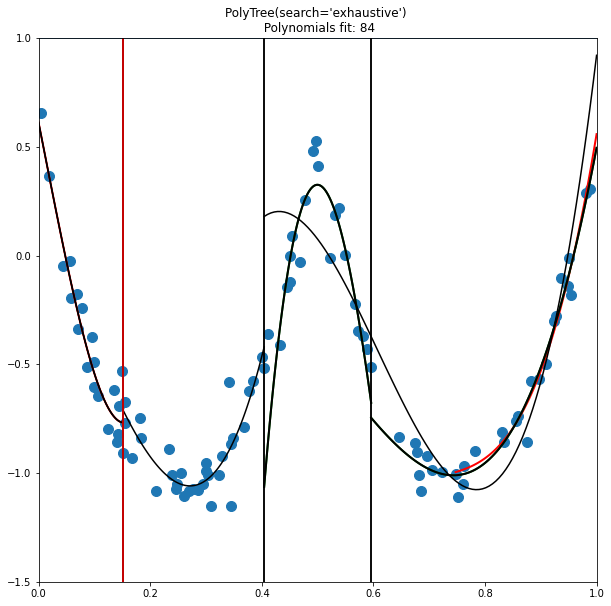

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set(xlim=(0, 1), ylim=(-1.5, 1))
ax.scatter(X, y, s=100)

try_line = []
try_line.append(ax.axhline(1))

best_line = []
best_line.append(ax.axhline(1))

fixed_line = []
fixed_line.append(ax.axhline(1))

left_try_poly, = ax.plot([], [], lw=2, color="red")
right_try_poly, = ax.plot([], [], lw=2, color="red")

left_best_poly, = ax.plot([], [], lw=2, color="green")
right_best_poly, = ax.plot([], [], lw=2, color="green")

left_fixed_poly, = ax.plot([], [], lw=2, color="black")
right_fixed_poly, = ax.plot([], [], lw=2,color="black")

fixed_polys = []
splits = [0, 1]
dirs = []

def boundary(threshold, direction):
    if direction == "left":
        left = max([split for split in splits if split < threshold])
        return left
    elif direction == "right":
        right = min([split for split in splits if split > threshold])
        return right
n = 0
def animate(log):
    global n
    if log["event"] == "UP":
        try:fixed_polys.pop()
        except:pass
        try:splits.pop()
        except:pass
        try:best_line[-1].remove()
        except:pass
        try:dirs.pop()
        except:pass
        
    if log["event"] == "DOWN":
        splits.append(log["data"]["threshold"])

        fixed_line.append(ax.axvline(log["data"]["threshold"], color='black'))
        
        if log["data"]["direction"] == "LEFT":
            fixed_polys.append(ax.plot(right_fixed_poly.get_xdata(),right_fixed_poly.get_ydata(),color="black"))
            right_fixed_poly.set_data(deepcopy(right_best_poly.get_xdata()), deepcopy(right_best_poly.get_ydata()))
            dirs.append("left")
            
        if log["data"]["direction"] == "RIGHT":
            fixed_polys.append(ax.plot(left_fixed_poly.get_xdata(),left_fixed_poly.get_ydata(),color="black"))
            left_fixed_poly.set_data(deepcopy(left_best_poly.get_xdata()), deepcopy(left_best_poly.get_ydata()))
            dirs.append("right")
            
    if log["event"] == "try_split":
        try_line[-1].remove()
        try_line.append(ax.axvline(log["data"]["threshold"], color='red'))
 
        x_test = np.reshape(np.linspace(boundary(log["data"]["threshold"], "left"), log["data"]["threshold"], 100), (100, 1))
        left_try_poly.set_data(x_test, log["data"]["poly_left"].get_polyfit(x_test))
                        
        x_test = np.reshape(np.linspace(log["data"]["threshold"], boundary(log["data"]["threshold"], "right"), 100), (100, 1))
        right_try_poly.set_data(x_test, log["data"]["poly_right"].get_polyfit(x_test))
        
        n+=1
    if log["event"] == "best_split":
        try:best_line[-1].remove()
        except:pass
        
        best_line.append(ax.axvline(log["data"]["threshold"], color='green'))
         
        x_test = np.reshape(np.linspace(boundary(log["data"]["threshold"], "left"), log["data"]["threshold"], 100), (100, 1))
        left_best_poly.set_data(x_test, log["data"]["poly_left"].get_polyfit(x_test))
                        
        x_test = np.reshape(np.linspace(log["data"]["threshold"], boundary(log["data"]["threshold"], "right"), 100), (100, 1))
        right_best_poly.set_data(x_test, log["data"]["poly_right"].get_polyfit(x_test))
        
        left_try_poly.set_data([],[])
        right_try_poly.set_data([],[])
        
        n+=1
    ax.set_title('PolyTree(search=\'exhaustive\') \n Polynomials fit: ' + str(n))

anim_1d = FuncAnimation(fig, animate, interval=duration * 1000 / len(tree.log) * 20, frames=tree.log)
HTML(anim_1d.to_html5_video())

In [7]:
def f_2(x1,x2):
    noise = 0.1 * st.norm.rvs(0, 1)
    return np.exp(-(x1**2 + x2**2) + noise)

def sample_2():
    X, y = [], []
    for i in range(150):
        x1, x2 = random.random(), random.random()        
        X.append(np.array([x1, x2]))
        y.append(np.array(f_2(x1, x2)))
    return np.array(X), np.array(y)

X, y = sample_2()
y = np.reshape(y, (y.shape[0], 1))
print(X.shape)
tree = polytree.PolyTree(min_samples_leaf=20, logging=True)

start = time.time()
tree.fit(X, y)
duration = time.time() - start

(150, 2)


In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set(xlim=(0, 1), ylim=(0, 1))
ax.scatter([x[0] for x in X], [x[1] for x in X], s=100, c=y)

try_line = []
try_line.append(ax.axhline(1))

best_line = []
best_line.append(ax.axhline(1))

fixed_line = []
fixed_line.append(ax.axhline(1))

tree_pos = []

def get_boundaries(j_feature, threshold):
    j_min, j_max = [0, 0], [1, 1]
    for node in tree_pos:
        if node["direction"] == "LEFT" and node["j_feature"] == 0:
            j_max[1] = node["threshold"]
        elif node["direction"] == "LEFT" and node["j_feature"] == 1:
            j_max[0] = node["threshold"]
        elif node["direction"] == "RIGHT" and node["j_feature"] == 0:
            j_min[1] = node["threshold"]
        elif node["direction"] == "RIGHT" and node["j_feature"] == 1:
            j_min[0] = node["threshold"]
    return j_min, j_max

n = 0
def animate(log):
    global n
    
    if log["event"] == "UP":
        try:tree_pos.pop()
        except:pass
        try:best_line[-1].remove()
        except:pass
        
    if log["event"] == "DOWN":
        tree_pos.append(log["data"])

        j_min, j_max = get_boundaries(log["data"]["j_feature"], log["data"]["threshold"])
        if log["data"]["j_feature"] == 0:
            fixed_line.append(ax.axvline(log["data"]["threshold"], ymin = j_min[0], ymax = j_max[0], color='black'))
        else:
            fixed_line.append(ax.axhline(log["data"]["threshold"], xmin = j_min[1], xmax = j_max[1], color='black'))
          
        try:best_line[-1].remove()
        except:pass
        try:try_line[-1].remove()
        except:pass
        
    if log["event"] == "try_split":
        j_min, j_max = get_boundaries(log["data"]["j_feature"], log["data"]["threshold"])
        if log["data"]["j_feature"] == 0:
            try:try_line[-1].remove()
            except:pass
            try_line.append(ax.axvline(log["data"]["threshold"], ymin = j_min[0], ymax = j_max[0], color='red'))
        else:
            try:try_line[-1].remove()
            except:pass
            try_line.append(ax.axhline(log["data"]["threshold"], xmin = j_min[1], xmax = j_max[1], color='red'))
        n+=1
    if log["event"] == "best_split":
        j_min, j_max = get_boundaries(log["data"]["j_feature"], log["data"]["threshold"])
        if log["data"]["j_feature"] == 0:
            try:best_line[-1].remove()
            except:pass
            best_line.append(ax.axvline(log["data"]["threshold"], ymin = j_min[0], ymax = j_max[0], color='green'))
        else:
            try:best_line[-1].remove()
            except:pass
            best_line.append(ax.axhline(log["data"]["threshold"], xmin = j_min[1], xmax = j_max[1], color='green'))
        n+=1
    ax.set_title('PolyTree(search=\'exhaustive\') \n Polynomials fit: ' + str(n))

anim_2d = FuncAnimation(fig, animate, interval=duration * 10000 / len(tree.log), frames=tree.log)
HTML(anim_2d.to_html5_video())

In [ ]:
def f_2(x1,x2):
    noise = 0.1 * st.norm.rvs(0, 1)
    return np.exp(-(x1**2 + x2**2) + noise)

def sample_2():
    X, y = [], []
    for i in range(150):
        x1, x2 = random.random(), random.random()        
        X.append(np.array([x1, x2]))
        y.append(np.array(f_2(x1, x2)))
    return np.array(X), np.array(y)

X, y = sample_2()
y = np.reshape(y, (y.shape[0], 1))

tree = polytree.PolyTree(search='uniform', min_samples_leaf=20, logging=True)

start = time.time()
tree.fit(X, y)
duration = time.time() - start

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set(xlim=(0, 1), ylim=(0, 1))
ax.scatter([x[0] for x in X], [x[1] for x in X], s=100, c=y)

try_line = []
try_line.append(ax.axhline(1))

best_line = []
best_line.append(ax.axhline(1))

fixed_line = []
fixed_line.append(ax.axhline(1))

tree_pos = []

def get_boundaries(j_feature, threshold):
    j_min, j_max = [0, 0], [1, 1]
    for node in tree_pos:
        if node["direction"] == "LEFT" and node["j_feature"] == 0:
            j_max[1] = node["threshold"]
        elif node["direction"] == "LEFT" and node["j_feature"] == 1:
            j_max[0] = node["threshold"]
        elif node["direction"] == "RIGHT" and node["j_feature"] == 0:
            j_min[1] = node["threshold"]
        elif node["direction"] == "RIGHT" and node["j_feature"] == 1:
            j_min[0] = node["threshold"]
    return j_min, j_max

n = 0
def animate(log):
    global n
    
    if log["event"] == "UP":
        try:tree_pos.pop()
        except:pass
        try:best_line[-1].remove()
        except:pass
        
    if log["event"] == "DOWN":
        tree_pos.append(log["data"])

        j_min, j_max = get_boundaries(log["data"]["j_feature"], log["data"]["threshold"])
        if log["data"]["j_feature"] == 0:
            fixed_line.append(ax.axvline(log["data"]["threshold"], ymin = j_min[0], ymax = j_max[0], color='black'))
        else:
            fixed_line.append(ax.axhline(log["data"]["threshold"], xmin = j_min[1], xmax = j_max[1], color='black'))
          
        try:best_line[-1].remove()
        except:pass
        try:try_line[-1].remove()
        except:pass
        
    if log["event"] == "try_split":
        j_min, j_max = get_boundaries(log["data"]["j_feature"], log["data"]["threshold"])
        if log["data"]["j_feature"] == 0:
            try:try_line[-1].remove()
            except:pass
            try_line.append(ax.axvline(log["data"]["threshold"], ymin = j_min[0], ymax = j_max[0], color='red'))
        else:
            try:try_line[-1].remove()
            except:pass
            try_line.append(ax.axhline(log["data"]["threshold"], xmin = j_min[1], xmax = j_max[1], color='red'))
        n+=1
    if log["event"] == "best_split":
        j_min, j_max = get_boundaries(log["data"]["j_feature"], log["data"]["threshold"])
        if log["data"]["j_feature"] == 0:
            try:best_line[-1].remove()
            except:pass
            best_line.append(ax.axvline(log["data"]["threshold"], ymin = j_min[0], ymax = j_max[0], color='green'))
        else:
            try:best_line[-1].remove()
            except:pass
            best_line.append(ax.axhline(log["data"]["threshold"], xmin = j_min[1], xmax = j_max[1], color='green'))
        n+=1
    ax.set_title('PolyTree(search=\'uniform\') \n Polynomials fit: ' + str(n))

anim_2d = FuncAnimation(fig, animate, interval=duration * 10000 / len(tree.log), frames=tree.log)
HTML(anim_2d.to_html5_video())

In [8]:
X = np.linspace(0, 1, num=100)
y = np.concatenate((25*(X[0:50]-0.25)**2 - 1.0625, 25*(X[50:100]-0.75)**2 - 1.0625))


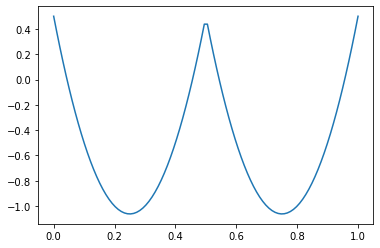

In [10]:
plt.plot(X,y)